In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def show_PIL_image(image):
    if(len(image.shape) < 3):
        image = image.unsqueeze(0)
    print(image)
    image = ToPILImage()(image.float())
    plt.imshow(image)
    plt.axis(False)
    plt.show()

In [ ]:
from Modules.ultis import DubaiAerialread
import albumentations as A
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

trans = transforms.ToTensor()

transforms_img = A.Compose([
    # A.RandomResizedCrop(256, 256),  # Random crop and resize
    A.HorizontalFlip(),  # Random horizontal flip
    A.VerticalFlip(),  # Random vertical flip
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),  # Convert to tensor
])

transforms_mask = transforms.Compose([
    transforms.RandomResizedCrop(size=(256, 256)),  # Random crop and resize
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),  # Random vertical flip
    transforms.ToTensor(),  # Convert to tensor
])

dataset = DubaiAerialread(data_path='data/Semantic segmentation dataset', transform=None)

image, mask = dataset[10]
print(type(mask))
show_PIL_image(image)
show_PIL_image(mask)

In [ ]:
from Modules.Detector import WrappingDetector
from torchvision.utils import draw_segmentation_masks
import PIL.Image as Image
from torchvision.io import read_image
import matplotlib.pyplot as plt
from Modules.ultis import PennFudanDataset
import torch

architect_settings = {
                        "name": "model-test",
                        "backbone": {
                                "name": "maskrcnn-s",
                                "is_full": True,
                                "is_pretrained": True,
                                "is_freeze": False, 
                        },
                        "n_cls": 2
                }

model = WrappingDetector(architect_settings)
model.eval()

dataset = PennFudanDataset(data_path="data/PennFudanPed")

# img = read_image("examples/dog-puppy-on-garden.jpg")
image, mask = dataset[10]
img_tensor = model.preprocess(image)

output = model([img_tensor], [mask])

score_threshold = .75
proba_threshold = 0.5

boolean_masks = [
    out['masks'][out['scores'] > score_threshold] > proba_threshold
    for out in output
][0]

segmet = draw_segmentation_masks((image * 255.).to(torch.uint8), boolean_masks.squeeze(), alpha=0.9)

plt.imshow(segmet.permute(1, 2 , 0))
plt.axis(False)
plt.show()

In [ ]:
from Modules.Segment import WrappingSegment
from torchvision.utils import draw_segmentation_masks
# import PIL.Image as Image
from torchvision.io import read_image
import matplotlib.pyplot as plt
# from Modules.ultis import PennFudanDataset
import torch

architect_settings = {
                        "name": "model-test",
                        "backbone": {
                                "name": "fcn-m",
                                "is_full": True,
                                "is_pretrained": True,
                                "is_freeze": False, 
                        },
                        "n_cls": 2
                }

model = WrappingSegment(architect_settings)
model.eval()

img = read_image("examples/Cat-or-Person-.jpg")
img_tensor = model.preprocess(img)

output = model(img_tensor.unsqueeze(0))

# normalized_masks = torch.nn.functional.softmax(output, dim=1)
num_classes = output.shape[1]
dog1_masks = output[0]
dog1_all_classes_masks = dog1_masks.argmax(0) == torch.arange(num_classes)[:, None, None]

segmet = draw_segmentation_masks((img * 255.).to(torch.uint8), dog1_all_classes_masks, alpha=0.5)

plt.imshow(segmet.permute(1, 2 , 0))
plt.axis(False)
plt.show()

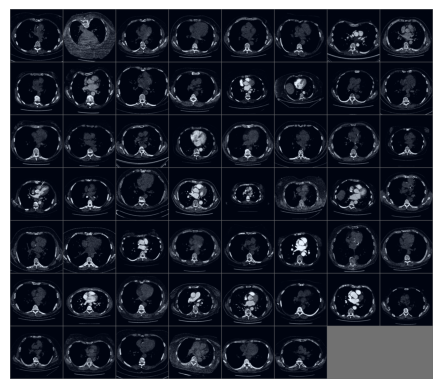

In [12]:
# write a test for DataModule class with visualization
from Modules.train import DataModule

dataset_settings= {
                    "name": "LungCT-Scan",
                    "path": "data/CT-scan-dataset",
                    "img_size": 224,
                    }
training_settings = {
                        "gpu_ids": [0],
                        "n_gpu": 1,
                        "loss": "ce",
                        "ckpt_path": "./mode/test",
                        "n_epoch": 50,
                        "n_batch": 64,
                        "num_workers": 12,
                        "optimizer": "adam",
                        "lr_scheduler": "step",
                        "early_stopping": False,
                        "lr": 0.0001,
                        "lr_step": 10,
                        "lr_decay": 0.8,
                        "momentum": 0.9,
                        "weight_decay": 0.005,
                }

data_module = DataModule(data_settings=dataset_settings, training_settings=training_settings)
data_module.setup(stage="test")
# load data from datamodule and visualize a sample
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
# load a data
data = next(iter(data_module.test_dataloader()))

# visualize a sample after normlize to 0-1 with max min normalization
def normalize_min_max(x):
    x = x - x.min()
    x = x / x.max()
    return x
# visualize
grid = make_grid(data[0], nrow=8)
grid = grid.permute(1, 2, 0)
grid = normalize_min_max(grid)
plt.imshow(grid)
plt.axis(False)
plt.show()

